In [3]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Data Loading & Dates Conversion: #

In [4]:
# Step 1: Load the sales data into a Pandas DataFrame
df = pd.read_csv("D:/internship/Retail_Store_Sales_Forecasting/data/retail_sales_mock_data.csv")  # Replace with your actual file path or URL

# Step 2: Convert the date column to datetime  
df['Date'] = pd.to_datetime(df['Date']) 

# set 'Date' as the index
df = df.set_index('Date')

# sort index chronological order
df = df.sort_index()  


## Understanding Datatset ##

In [5]:
df.head()

,SalesAmount,Promotion,HolidayMonth
Date,,,
2020-01-01,12248,0,0
2020-02-01,11712,0,0
2020-03-01,11423,0,0
2020-04-01,14030,1,0
2020-05-01,9082,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalesAmount   48 non-null     int64
 1   Promotion     48 non-null     int64
 2   HolidayMonth  48 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB


In [7]:
df.describe()

,SalesAmount,Promotion,HolidayMonth
count,48.000000,48.000000,48.000000
mean,11829.854167,0.125000,0.083333
std,2436.051837,0.334219,0.279310
min,8445.000000,0.000000,0.000000
25%,10369.000000,0.000000,0.000000
50%,11424.000000,0.000000,0.000000
75%,12799.250000,0.000000,0.000000
max,19753.000000,1.000000,1.000000


## Check Granularity & Aggregate to Monthly (if needed) ##

In [8]:
# Check the frequency by inspecting index differences
print(df.index.to_series().diff().value_counts().head())

Date
31 days    27
30 days    16
28 days     3
29 days     1
Name: count, dtype: int64


## Resample to Monthly Sales ##

In [9]:
# If data is not monthly, aggregate to monthly
df_monthly = df.resample('M').sum()  # 'M' = month-end frequency

# Preview monthly data
print(df_monthly.head())


            SalesAmount  Promotion  HolidayMonth
Date                                            
2020-01-31        12248          0             0
2020-02-29        11712          0             0
2020-03-31        11423          0             0
2020-04-30        14030          1             0
2020-05-31         9082          0             0


C:\Users\OceanComputers\AppData\Local\Temp\ipykernel_11504\1350513894.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()  # 'M' = month-end frequency


## Handling Missing Values ##

In [10]:
# Check for missing values
missing_count = df_monthly.isna().sum()
print("Missing values before handling:", missing_count)

Missing values before handling: SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64


No missing values. If there are missing values we can use following methods to fill missing values.

In [11]:
# Fill missing values using forward fill (or interpolate if needed)
# df_monthly = df_monthly.fillna(method='ffill')
# df_monthly = df_monthly.interpolate()  # Alternative method

## Handling Duplicate Values ##

In [12]:
duplicates = df[df.duplicated()]
print(duplicates) 

Empty DataFrame
Columns: [SalesAmount, Promotion, HolidayMonth]
Index: []


## Handiling Outliers ##

In [13]:
# Calculate Z-scores
z_scores = zscore(df_monthly)

In [14]:
# Mark points with Z-score > 3 as outliers
outliers = np.abs(z_scores) > 3

In [15]:
# Replace outliers with NaN
df_monthly[outliers] = np.nan

In [16]:
# Interpolate over the NaNs introduced by outlier removal
df_monthly = df_monthly.interpolate()

## Decomposition Plot ##

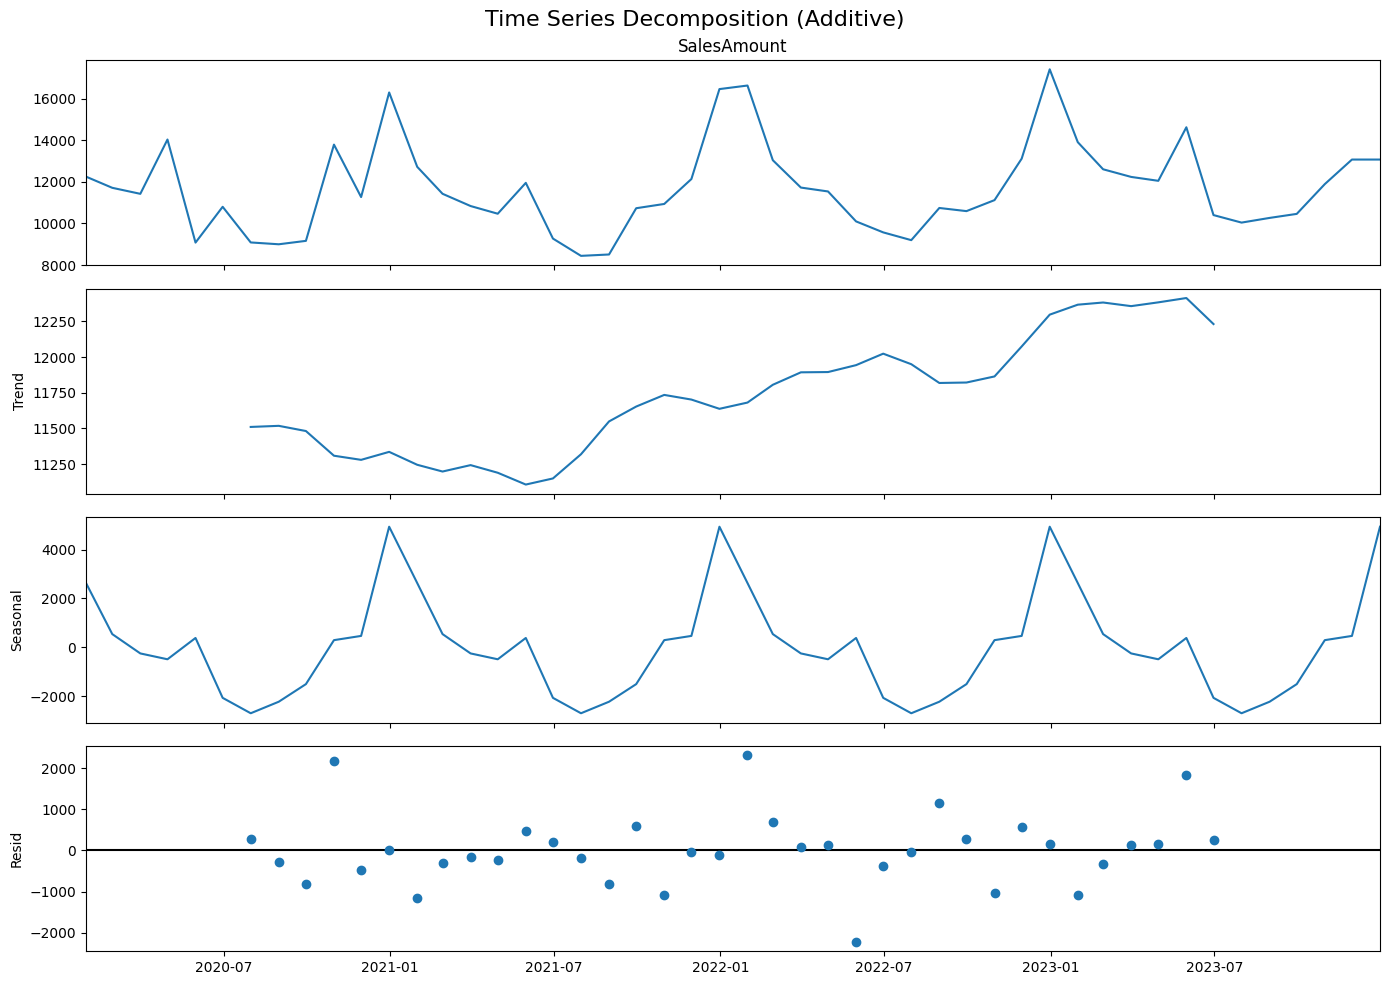

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Apply additive decomposition
decomposition = seasonal_decompose(df_monthly['SalesAmount'], model='additive', period=12)

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Time Series Decomposition (Additive)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


## ACF and PACF Plots ##

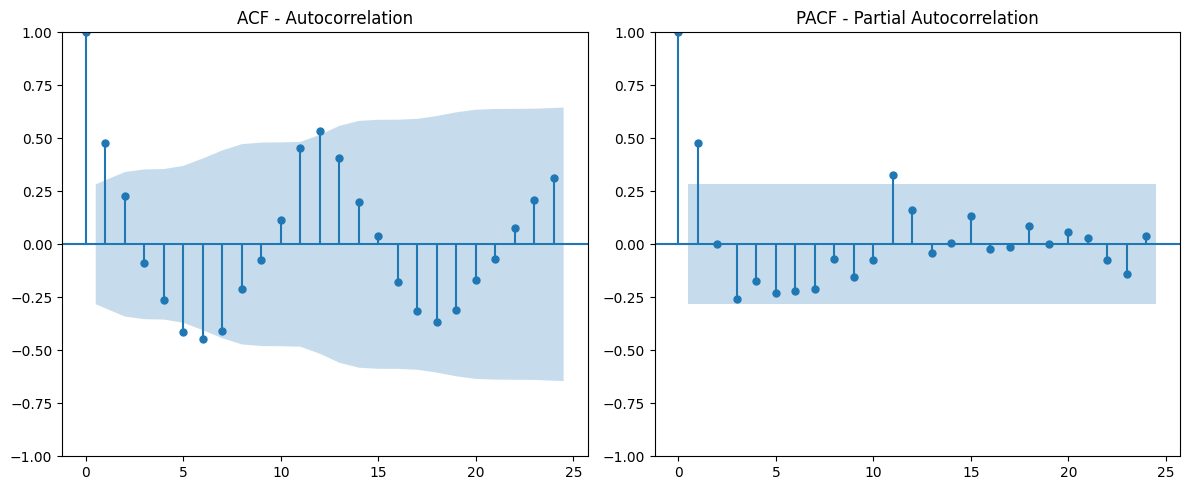

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(df_monthly['SalesAmount'], lags=24, ax=plt.gca())
plt.title("ACF - Autocorrelation")

plt.subplot(1, 2, 2)
plot_pacf(df_monthly['SalesAmount'], lags=24, ax=plt.gca(), method='ywm')
plt.title("PACF - Partial Autocorrelation")

plt.tight_layout()
plt.show()


## Dickey-Fuller Test for Stationarity ##

In [19]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
adf_result = adfuller(df_monthly['SalesAmount'].dropna())

# Display results
print("=== Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("✅ The series is stationary (reject H0).")
else:
    print("⚠️ The series is non-stationary (fail to reject H0). Consider differencing.")


=== Dickey-Fuller Test ===
ADF Statistic: -1.7705
p-value: 0.3952
Critical Values:
   1%: -3.6209
   5%: -2.9435
   10%: -2.6104
⚠️ The series is non-stationary (fail to reject H0). Consider differencing.


# Differencing (for stationarity) #

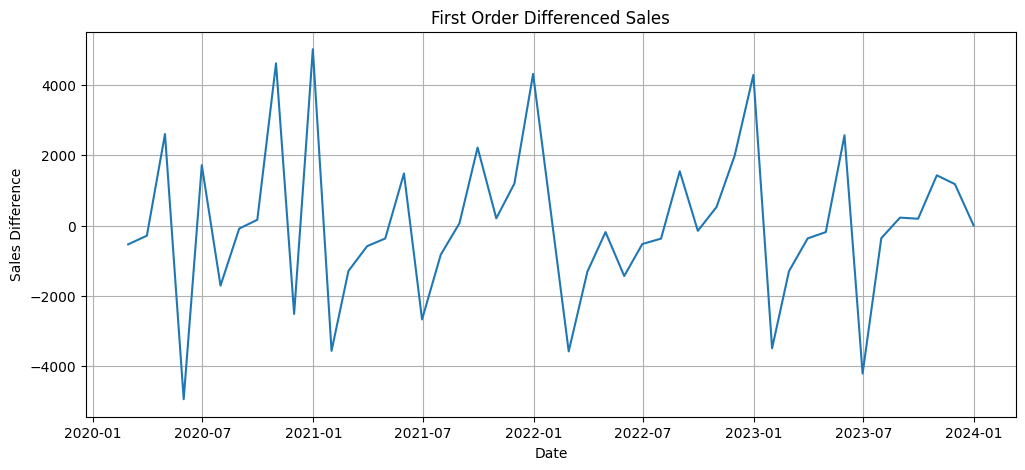

In [20]:
# First order differencing
df_monthly['Sales_diff1'] = df_monthly['SalesAmount'].diff()

# Drop the first NaN
df_diff = df_monthly.dropna(subset=['Sales_diff1'])

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(df_diff.index, df_diff['Sales_diff1'])
plt.title("First Order Differenced Sales")
plt.xlabel("Date")
plt.ylabel("Sales Difference")
plt.grid(True)
plt.show()

In [22]:
# Check stationarity again
result_diff = adfuller(df_diff['Sales_diff1'])
print("\nDickey-Fuller Test After Differencing:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
for key, value in result_diff[4].items():
    print(f"Critical Value {key}: {value}")

if result_diff[1] < 0.05:
    print("✅ The differenced series is stationary.")
else:
    print("⚠️ The series still might not be stationary.")


Dickey-Fuller Test After Differencing:
ADF Statistic: -5.428228727011927
p-value: 2.9541909072691157e-06
Critical Value 1%: -3.626651907578875
Critical Value 5%: -2.9459512825788754
Critical Value 10%: -2.6116707716049383
✅ The differenced series is stationary.
